In [1]:
import os 
from super_gradients.training import Trainer
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from dotenv import load_dotenv
import cv2 
import supervision as sv
import torch 


/home/lpalombi/Desktop/YOLONAS_Training/myenv/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
[2024-06-20 15:53:04] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/lpalombi/sg_logs/console.log


[2024-06-20 15:53:06] INFO - check_version.py - A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
!nvidia-smi # check GPU availability 


In [3]:
# Declare paths
HOME = os.getcwd()
LOCATION = f'{HOME}/vehicles'
CHECKPOINT_DIR = f'{HOME}/checkpoints'

print(LOCATION)

In [4]:
# Declare constraints 
MODEL_ARCH = 'yolo_nas_s' # model architecture load from .env (yolo nas s)
EXPERIMENT_NAME = 'vehicles' # name of experiment (data folder)
CLASSES = ['0'] # Array of class label names. Found in YAML file. 
BATCH_SIZE = 8 # # of batches
MAX_EPOCHS = 25 # # of epochs
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"


In [5]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [6]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [7]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'show_all_warnings': True,
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

Thu Jun 20 15:53:07 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0  On |                  N/A |
|  0%   53C    P8    26W / 320W |    573MiB / 10240MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/home/lpalombi/Desktop/YOLONAS_Training/vehicles


[2024-06-20 15:53:08] WARNING - yolo_format_detection.py - 9 images are note associated to any label file
[2024-06-20 15:53:08] WARNING - yolo_format_detection.py - As a consequence, 433/442 images and 433/433 label files will be used.
[2024-06-20 15:53:08] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 433/433 [00:00<00:00, 5242.44it/s]
[2024-06-20 15:53:08] WARNING - yolo_format_detection.py - 1 images are note associated to any label file
[2024-06-20 15:53:08] WARNING - yolo_format_detection.py - As a consequence, 54/55 images and 54/54 label files will be used.
[2024-06-20 15:53:08] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 54/54 [00:00<00:00, 2847.06it/s]
[2024-06-20 15:5

In [8]:
train_data.dataset.transforms

In [9]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

Indexing dataset annotations: 100%|██████████| 53/53 [00:00<00:00, 3284.45it/s]


[2024-06-20 15:53:08] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-06-20 15:53:08] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-06-20 15:53:08] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


In [10]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [11]:
# trainer.train(
#     model=model,
#     training_params=train_params,
#     train_loader=train_data,
#     valid_loader=val_data
# )

In [12]:
%load_ext tensorboard
%tensorboard --logdir {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

Reusing TensorBoard on port 6006 (pid 162758), started 0:05:37 ago. (Use '!kill 162758' to kill it.)

In [13]:
# !zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

In [14]:
SAVE_FOLDER = "RUN_20240620_125142_450900"

checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/{SAVE_FOLDER}/ckpt_best.pth"
print(checkpoint_path)

best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/{SAVE_FOLDER}/ckpt_best.pth"
).to(DEVICE)

/home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth


[2024-06-20 15:53:09] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/lpalombi/Desktop/YOLONAS_Training/checkpoints/vehicles/RUN_20240620_125142_450900/ckpt_best.pth EMA checkpoint.


In [15]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(dataset_params['classes']),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )
)

""""
    Analysis: 
{'PPYoloELoss/loss_cls': 0.61581695,
 'PPYoloELoss/loss_iou': 0.3107958,
 'PPYoloELoss/loss_dfl': 0.32488734,
 'PPYoloELoss/loss': 1.2515001,
 'Precision@0.50': 0.17845658957958221,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.9908557534217834,
 'F1@0.50': 0.3028649389743805,
 'Best_score_threshold': 0.6700000166893005}


 
'PPYoloELoss/loss_cls': 0.61581695: High classification loss, model struggles to differentiate 
between objects/backgrounds or diff object classes 

'PPYoloELoss/loss_iou': 0.3107958: Moderate, boxes aren't perfect but its an improvement

'PPYoloELoss/loss_dfl': 0.32488734: Overall loss shows improvement to prev. set 


'Precision@0.50': 0.17845658957958221: Very high number of false positives. Detects many objects 
that are not present. 

 'Recall@0.50': 1.0: Very unlikely recall. Model is overfitting. Indicates dataset thats too small. 

 ... etc. 

 To improve: Need a better precision/recall balance. 

 - Data augmentation like random cropping, flipping, color jittering, etc. Artificially 
 increase size/diversity of training data. 
- Regularization techniques like L1/L2 weight decay or dropout layers **** helps model perform well on unseen data. 
- Hyperparameter tuning: learning rate, batch size, optimizer settings, etc..


"""

Testing:  86%|████████▌ | 6/7 [00:08<00:01,  1.39s/it]

'"\n    Analysis: \n{\'PPYoloELoss/loss_cls\': 0.61581695,\n \'PPYoloELoss/loss_iou\': 0.3107958,\n \'PPYoloELoss/loss_dfl\': 0.32488734,\n \'PPYoloELoss/loss\': 1.2515001,\n \'Precision@0.50\': 0.17845658957958221,\n \'Recall@0.50\': 1.0,\n \'mAP@0.50\': 0.9908557534217834,\n \'F1@0.50\': 0.3028649389743805,\n \'Best_score_threshold\': 0.6700000166893005}\n\n\n \n\'PPYoloELoss/loss_cls\': 0.61581695: High classification loss, model struggles to differentiate \nbetween objects/backgrounds or diff object classes \n\n\'PPYoloELoss/loss_iou\': 0.3107958: Moderate, boxes aren\'t perfect but its an improvement\n\n\'PPYoloELoss/loss_dfl\': 0.32488734: Overall loss shows improvement to prev. set \n\n\n\'Precision@0.50\': 0.17845658957958221: Very high number of false positives. Detects many objects \nthat are not present. \n\n \'Recall@0.50\': 1.0: Very unlikely recall. Model is overfitting. Indicates dataset thats too small. \n\n ... etc. \n\n To improve: Need a better precision/recall balan

In [16]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{LOCATION}/test/images",
    annotations_directory_path=f"{LOCATION}/test/labels",
    data_yaml_path=f"{LOCATION}/data.yaml",
    force_masks=False
)

Testing: 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


In [17]:
import supervision as sv

CONFIDENCE_TRESHOLD = 0.5

predictions = {}

for image_name, image in ds.images.items():
    result = best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int)
    )
    predictions[image_name] = detections

[2024-06-20 15:53:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


[2024-06-20 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-06-20 15:53:21] INFO -

In [18]:
import random
random.seed(10)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `B

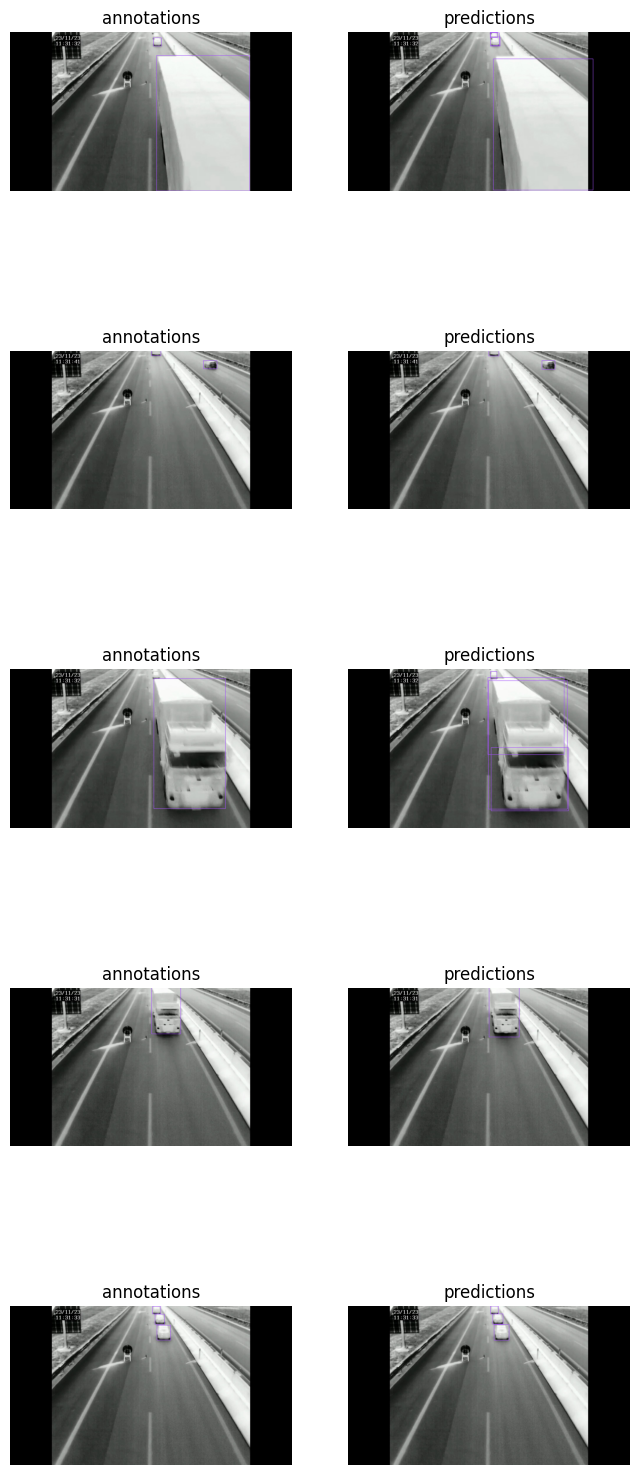

In [19]:
import supervision as sv

MAX_IMAGE_COUNT = 5

n = min(MAX_IMAGE_COUNT, len(ds.images))

keys = list(ds.images.keys())
keys = random.sample(keys, n)

box_annotator = sv.BoxAnnotator()

images = []
titles = []

for key in keys:
    frame_with_annotations = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=ds.annotations[key],
        skip_label=True
    )
    images.append(frame_with_annotations)
    titles.append('annotations')
    frame_with_predictions = box_annotator.annotate(
        scene=ds.images[key].copy(),
        detections=predictions[key],
        skip_label=True
    )
    images.append(frame_with_predictions)
    titles.append('predictions')

%matplotlib inline
sv.plot_images_grid(images=images, titles=titles, grid_size=(n, 2), size=(2 * 4, n * 4))

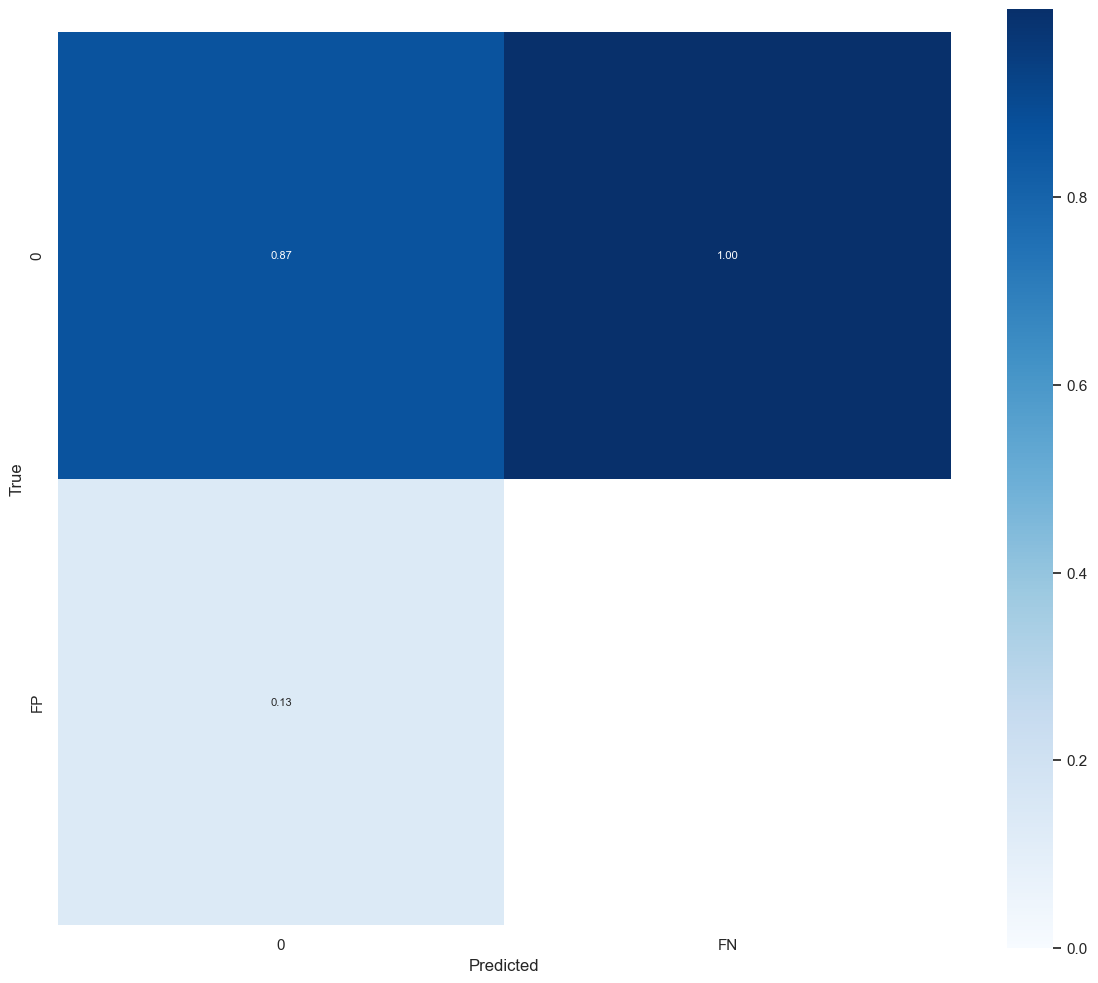

In [20]:

import os

import numpy as np

from onemetric.cv.object_detection import ConfusionMatrix

keys = list(ds.images.keys())

annotation_batches, prediction_batches = [], []

for key in keys:
    annotation=ds.annotations[key]
    annotation_batch = np.column_stack((
        annotation.xyxy,
        annotation.class_id
    ))
    annotation_batches.append(annotation_batch)

    prediction=predictions[key]
    prediction_batch = np.column_stack((
        prediction.xyxy,
        prediction.class_id,
        prediction.confidence
    ))
    prediction_batches.append(prediction_batch)

confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=annotation_batches,
    detection_batches=prediction_batches,
    num_classes=len(ds.classes),
    conf_threshold=CONFIDENCE_TRESHOLD
)

confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=ds.classes)
     

# Convert to ONNX

In [21]:
# from ultralytics import NAS, YOLO
# import openvino as ov 
from torch.autograd import Variable 

best_model.cpu()
#models.convert_to_onnx(model=best_model, prep_model_for_conversion_kwargs={'input_size':[ 1, 3, 640, 640]}, out_path="yolo_nasl.onnx")
# need size 640 x 640 for PTQ (H, W)

# For now, padd 1080 to 1088 on the right
models.convert_to_onnx(model=best_model, out_path="yolo_nas_s.onnx", prep_model_for_conversion_kwargs={'input_size':[1, 3, 1088, 1920]})


'yolo_nas_s.onnx'

# Quantize 

In [22]:
from ultralytics.engine.validator import BaseValidator as Validator
from ultralytics.cfg import get_cfg
from ultralytics.utils import DEFAULT_CFG
import nncf
# from openvino.tools.mo import convert_model 
import openvino.runtime as ov
import onnx 
from openvino.runtime import serialize


In [23]:
model_path = f"{HOME}/yolo_nas_s.onnx"
model = onnx.load(model_path)

In [76]:
class LoadData: 
    
    data_items = []
    data_dir = ''

    def __init__(self, data_dir): 
        self.data_dir = data_dir 
        self.data_items = []
        self.current = 0 

        self.load_data(data_dir)

    def __iter__(self): 
        return self  
    
    def __next__(self): 
        if self.current >= len(self.data_items): 
            raise StopIteration 
        else: 
            data_item = self.data_items[self.current]
            self.current+=1 
            return data_item 

    
    def load_data(self, data_dir): 
        images = data_dir + '/images/'
        labels = data_dir + '/labels/'

        for i in os.listdir(images): 
            img_filename = os.fsdecode(i) # Get file name 
            img_name = img_filename.split('.jpg')[0] # remove extension 

            for j in os.listdir(labels): 
                txt_filename = os.fsdecode(j)
                txt_name = txt_filename.split('.txt')[0]

                if(txt_name==img_name): 
                    path = images + img_filename 
                    img = cv2.imread(path)
                    img = img.astype(np.float32) / 255.0
                    img = img[np.newaxis, ...]
                    img = img.reshape(1, 3, 1080, 1920)
                    # print(img.shape)
                    data_item = DataItem(img, labels + txt_filename, images + img_name, img_name)
                    self.data_items.append(data_item)
                    break 

class DataItem: 
    data = [0, ''] # image data, text path 
    img_path = ''
    name=''

    def __init__(self, image_data=0, text_path='', img_path='', name=''): 
        self.data[0] = image_data
        self.data[1] = text_path 
        self.img_path = img_path
        self.name = name 

    def setImagePath(self, path): 
        self.img_path = path 

    def setName(self, name):
        self.name = name  

    def getData(self): 
        return self.data
    
    def getName(self): 
        return self.name 

In [50]:
# # Testing
# import cv2 
# from matplotlib import pyplot as plt 
# img_path = f"{HOME}/vehicles/test/images/frame_0466.jpg"
# img = cv2.imread(img_path)
# plt.imshow(img)
# print(img.shape)
# # img = img[np.newaxis, ...]
# # # img = img.reshape(1, 3, 640, 640)
# plt.imshow(img)



In [52]:
def transform_fn(data_item): 
    img = data_item
    return {model.graph.input[0].name: img.getData()[0]}

In [75]:
DATA = f"{HOME}/vehicles/valid"

args = get_cfg(cfg=DEFAULT_CFG)
args.data = f"{HOME}/vehicles/data.yaml"

val_dataset = LoadData(DATA)
model_path = f"{HOME}/yolo_nas_s.onnx"
model = onnx.load(model_path)

calibration_dataset = nncf.Dataset(val_dataset, transform_fn)

quantized_model = nncf.quantize(model, calibration_dataset)

onnx.save(quantized_model, "quantized_model.onnx")

(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 1080, 1920, 3)
(1080, 1920, 3)
(1, 

UserWarning: install "ipywidgets" for Jupyter support

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
 index: 1 Got: 1080 Expected: 3
 index: 2 Got: 1920 Expected: 1088
 index: 3 Got: 3 Expected: 1920
 Please fix either the inputs or the model.